<a href="https://colab.research.google.com/github/AndreasGeorgiou03/PINODEs/blob/main/PINODE_Exp3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchdiffeq

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchdiffeq import odeint
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 1. Problem setup: 4-DOF

# Parameters
c1 = c2 = c3 = 0.015
m1 = m2 = 9.0
m3 = 9.2


# Stiffness matrix K for a 3-DOF
K = torch.tensor([
    [20.26,   -11.16,   0.0],
    [-11.16,  20.33,    -9.17],
    [0.0,      -9.17,     9.17],
], dtype=torch.float32, device=device)

# Damping matrix (diagonal with c1..c3)
C = torch.diag(torch.tensor([c1, c2, c3], dtype=torch.float32, device=device))

# Mass Matrix
M = (1.0/386) * torch.diag(torch.tensor([m1, m2, m3], dtype=torch.float32, device=device))

r = torch.ones(3, device=device)          # participation vector
B = -(M @ r)      # (3,)

# Initial conditions for this experiment)
h0_1 = torch.tensor([ 2.0,  0.0, 0.0, 0.0,  0.0, -2.0, 0.0, 0.0], dtype=torch.float32, device=device)
h0_2 = torch.tensor([-2.0,  0.0, 0.0, -2.0,  0.0, 0.0], dtype=torch.float32, device=device)
h0_3 = torch.tensor([ 0.0,  4.0, 0.0, 0.0,  0.0,  0.0, 0.0, 0.0], dtype=torch.float32, device=device)
h0_4 = torch.tensor([ 0.0,  0.0, 0.0, 0.0,  0.0,  0.0, 0.0, 0.0], dtype=torch.float32, device=device)

h0_train = [h0_2]

dt = 1.0 / 256.0
t_train = torch.arange(0.0, 5.0 + dt, dt, device=device)  # dt comes from spacing here
t_full  = torch.arange(0.0, 12.52 + dt, dt, device=device)


Using device: cpu


In [4]:
import re

def load_at2(path: str, device, dtype=torch.float32, dt_fallback=1/256):

    with open(path, "r") as f:
        lines = f.readlines()

    dt = float(dt_fallback)

    # Find where numeric data starts (first line that contains a float)
    start_idx = None
    float_re = re.compile(r"[-+]?\d*\.?\d+(?:[Ee][-+]?\d+)?")

    for i, line in enumerate(lines):
        # If this line contains at least one float-like token, assume data begins here
        if float_re.search(line):
            # avoid picking up header lines that only contain NPTS/DT text with numbers.
            # if the line has MANY floats or mostly numeric tokens, it's data.
            tokens = float_re.findall(line)
            if len(tokens) >= 3:  # data lines usually have multiple numbers
                start_idx = i
                break

    if start_idx is None:
        raise ValueError("Could not locate numeric acceleration data in the AT2 file.")

    # Parse all floats from start_idx onward as the accel series
    data_str = " ".join(lines[start_idx:])
    data = np.array([float(x) for x in float_re.findall(data_str)], dtype=np.float32)

    if data.size == 0:
        raise ValueError("Parsed zero acceleration samples from the AT2 file.")

    ag = torch.tensor(data, device=device, dtype=dtype)
    t  = torch.arange(0.0, ag.numel() * dt, dt, device=device, dtype=dtype)

    return t, ag, dt


In [5]:
# Load Kobe AT2
kobe_path = "/content/drive/MyDrive/20251212_1765548540.60025_1/ath.KOBE.KBU000.AT2"
t_all, ag_all, dt = load_at2(kobe_path, device=device)

fs = 1.0 / dt
N_train = len(t_train)
N_full  = len(t_full)

u_train = ag_all[:N_train]   # ground accel for training
u_full  = ag_all[:N_full]    # ground accel for full horizon

In [6]:
class PINODEFuncScheme3_3DOF(nn.Module):
    def __init__(self, M, K, C, B):
        super().__init__()
        self.M = nn.Parameter(M.clone(), requires_grad=False)
        self.K = nn.Parameter(K.clone(), requires_grad=False)
        self.C = nn.Parameter(C.clone(), requires_grad=False)
        self.B = nn.Parameter(B.clone().view(3), requires_grad=False)

        self.amp = 1.0
        self.u_fun = lambda t: torch.zeros((), device=self.M.device)  # scalar tensor

        # NN1: linear (no activation), 1 hidden layer with 10 neurons
        self.mlp = nn.Sequential(
            nn.Linear(6, 10),
            nn.Linear(10, 3)
        )

    def forward(self, t, h):
        x = h[..., :3]
        v = h[..., 3:]

        rhs = (- self.K @ x.unsqueeze(-1) - self.C @ v.unsqueeze(-1)).squeeze(-1)

        u_t = self.amp * self.u_fun(t)     # scalar
        rhs = rhs + self.B * u_t           # (3,) broadcast

        a_phys = torch.linalg.solve(self.M, rhs.unsqueeze(-1)).squeeze(-1)  # (3,)

        a_disc = self.mlp(h)               # (3,)
        a = a_phys + a_disc

        dh = torch.zeros_like(h)
        dh[..., :3] = v
        dh[..., 3:] = a
        return dh


In [7]:
# Start from nominal
M_true = M.clone()
K_true = K.clone()
C_true = C.clone()

# Add controlled mismatch
K_true = 0.97 * K_true  # stiffness is 3% lower than nominal
C_true = 1.25 * C_true  # damping is 25% higher than nominal

# Base excitation forcing vector for true system
B_true = -(M_true @ r)      # (3,)

class TruthLinear3DOF(nn.Module):

    def __init__(self, M, K, C, B):
        super().__init__()
        self.M = M
        self.K = K
        self.C = C
        self.B = B
        self.amp = 1.0
        self.u_fun = None  # set later

    def forward(self, t, h):
        x = h[..., :3]
        v = h[..., 3:]

        rhs = (- self.K @ x.unsqueeze(-1) - self.C @ v.unsqueeze(-1)).squeeze(-1)
        rhs = rhs + self.B * (self.amp * self.u_fun(t))

        a = torch.linalg.solve(self.M, rhs.unsqueeze(-1)).squeeze(-1)

        dh = torch.zeros_like(h)
        dh[..., :3] = v
        dh[..., 3:] = a
        return dh


In [8]:
class UFunFromSamples:

    def __init__(self, t_grid: torch.Tensor, u_grid: torch.Tensor):
        assert t_grid.ndim == 1 and u_grid.ndim == 1, "t_grid and u_grid must be 1D"
        assert t_grid.numel() == u_grid.numel(), "t_grid and u_grid must have same length"
        self.t = t_grid
        self.u = u_grid

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        # Accept scalar or vector t; return same shape
        t_in = t.reshape(-1)

        t0 = self.t[0]
        dt = self.t[1] - self.t[0]
        T = self.t.numel()

        # Convert t -> fractional index in [0, T-1)
        idx = ((t_in - t0) / dt).clamp(0, T - 1 - 1e-6)

        i0 = torch.floor(idx).long()
        i1 = (i0 + 1).clamp_max(T - 1)

        w = (idx - i0.float()).clamp(0.0, 1.0)

        out = (1.0 - w) * self.u[i0] + w * self.u[i1]
        return out.reshape(t.shape)


In [22]:
truth = TruthLinear3DOF(M_true, K_true, C_true, B_true).to(device)
truth.u_fun = UFunFromSamples(t_train, u_train)

# Forcing on full horizon
N_full = len(t_full)
u_full = ag_all[:N_full].to(device)  # (N_full,)

# define forcing function on the full horizon
u_fun_full = UFunFromSamples(t_full, u_full)

with torch.no_grad():
    traj_meas_full = odeint(truth, h0_2, t_full, method="rk4")  # (T_full, 6)


N_train = len(t_train)
u_train = u_full[:N_train]              # (T_train,)

traj_meas_train = traj_meas_full[:N_train]  # (T_train, 6)

In [11]:
def train_scheme_with_disc_singleIC_singleEQ_exp3_no_nsd(scheme,model,h0,traj_true,t_train,u_grid,amp_scale=1.0,num_epochs=4000,lr=1e-3,log_interval=20,loss_log_path=None,loss_history_init=None,save_model_path=None):
    model = model.to(device)
    model.train()

    # Set forcing (single record)
    model.u_fun = UFunFromSamples(t_train, u_grid.to(device))
    model.amp = float(amp_scale)

    opt = optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    w1_before = model.mlp[0].weight.detach().clone()

    # --------- resume logic ----------
    if loss_history_init is None:
        loss_history_list = []
        global_epoch = 0
    else:
        if isinstance(loss_history_init, np.ndarray):
            loss_history_list = loss_history_init.tolist()
        else:
            loss_history_list = list(loss_history_init)
        global_epoch = int(loss_history_list[-1][0]) if len(loss_history_list) > 0 else 0
    # -------------------------------

    # Shape checks
    traj_true = traj_true.to(device)
    assert traj_true.ndim == 2
    assert traj_true.shape[0] == len(t_train)


    # ---- loss normalization ----
    state_dim = traj_true.shape[1]
    ndof = state_dim // 2

    x_true = traj_true[:, :ndof]   # displacements
    v_true = traj_true[:, ndof:]   # velocities

    eps = 1e-8
    sx = x_true.std(dim=0, unbiased=False) + eps   # (ndof,)
    sv = v_true.std(dim=0, unbiased=False) + eps   # (ndof,)
    # --------------------------------------


    print(f"\n=== Training single record (scheme {scheme}) for {num_epochs} epochs ===")
    print(f"amp_scale={amp_scale}")

    for local_epoch in range(1, num_epochs + 1):
        global_epoch += 1
        opt.zero_grad()

        pred = odeint(model, h0, t_train, method="rk4")  # (T, state_dim)
        assert pred.shape == traj_true.shape, f"pred.shape={pred.shape}, traj_true.shape={traj_true.shape}"

        x_pred = pred[:, :ndof]
        v_pred = pred[:, ndof:]

        loss_x = torch.mean(((x_pred - x_true) / sx) ** 2)
        loss_v = torch.mean(((v_pred - v_true) / sv) ** 2)

        # mild preference to displacement
        loss = 1.5 * loss_x + 1.0 * loss_v


        loss.backward()
        opt.step()

        if global_epoch % log_interval == 0:
            loss_history_list.append([global_epoch, float(loss.item())])

        if local_epoch % 100 == 1 or global_epoch % 100 == 0:
            print(
                f"[S{scheme}] Global {global_epoch:5d}, "
                f"Lx={loss_x.item():.3e}, Lv={loss_v.item():.3e}, "
                f"Total={loss.item():.3e}"
            )
        if save_model_path is not None and (local_epoch % 500 == 0):
            torch.save(model.state_dict(), save_model_path)
            print(f"Saved model to {save_model_path}")

        if loss_log_path is not None and (local_epoch % 500 == 0):
            np.save(loss_log_path, np.array(loss_history_list, dtype=np.float32))
            print(f"Saved partial loss history to {loss_log_path}")

    loss_history_arr = np.array(loss_history_list, dtype=np.float32)

    if save_model_path is not None:
        torch.save(model.state_dict(), save_model_path)
        print(f"Saved model to {save_model_path}")

    if loss_log_path is not None:
        np.save(loss_log_path, loss_history_arr)
        print(f"\nSaved loss history to: {loss_log_path}")

    return model, loss_history_arr


In [12]:

model = PINODEFuncScheme3_3DOF(M, K, C,B)

model.u_fun = UFunFromSamples(t_train, u_train)
model.amp = 1.0

save_path = "/content/drive/MyDrive/pinode_models/"

save_model_path = save_path + "exp3_5k_V2.pth"
loss_log_path = save_path + "exp3_5k_V2.npy"

model.load_state_dict(torch.load(save_model_path, map_location=device))

# model, loss_hist = train_scheme_with_disc_singleIC_singleEQ_exp3_no_nsd(
#     scheme=3,
#     model=model,
#     h0=h0_2,
#     traj_true=traj_meas_train,
#     t_train=t_train,
#     u_grid=u_train,
#     amp_scale=1.0,
#     num_epochs=5000,
#     lr=1e-3,
#     log_interval=20,
#     loss_log_path=loss_log_path,
#     save_model_path=save_model_path,
#     loss_history_init=None,
#     lambda_offdiag=1.0
# )




<All keys matched successfully>

In [13]:
# --- set the forcing on the full horizon ---
model.eval()
model.u_fun = UFunFromSamples(t_full, u_full)
model.amp = 1.0

# --- extrapolate ---
with torch.no_grad():
    pred_full = odeint(model, h0_2, t_full, method="rk4")  # (N_full, 6)

# pred_full contains [x1 x2 x3 v1 v2 v3]
x_pred_full = pred_full[:, :3]
v_pred_full = pred_full[:, 3:]


In [14]:
class PhysicsOnly3DOF(nn.Module):
    def __init__(self, M, K, C, B, t_grid, u_grid, amp=1.0):
        super().__init__()
        self.M, self.K, self.C, self.B = M, K, C, B
        self.u_fun = UFunFromSamples(t_grid, u_grid)
        self.amp = float(amp)

    def forward(self, t, h):
        x = h[..., :3]
        v = h[..., 3:]
        rhs = (-self.K @ x.unsqueeze(-1) - self.C @ v.unsqueeze(-1)).squeeze(-1)
        rhs = rhs + self.B * (self.amp * self.u_fun(t))
        a = torch.linalg.solve(self.M, rhs.unsqueeze(-1)).squeeze(-1)
        dh = torch.zeros_like(h)
        dh[..., :3] = v
        dh[..., 3:] = a
        return dh


In [15]:
phys_only = PhysicsOnly3DOF(M, K, C, B, t_full, u_full, amp=1.0).to(device)

with torch.no_grad():
    traj_phys_full = odeint(phys_only, h0_2, t_full, method="rk4")  # (T_full,6)


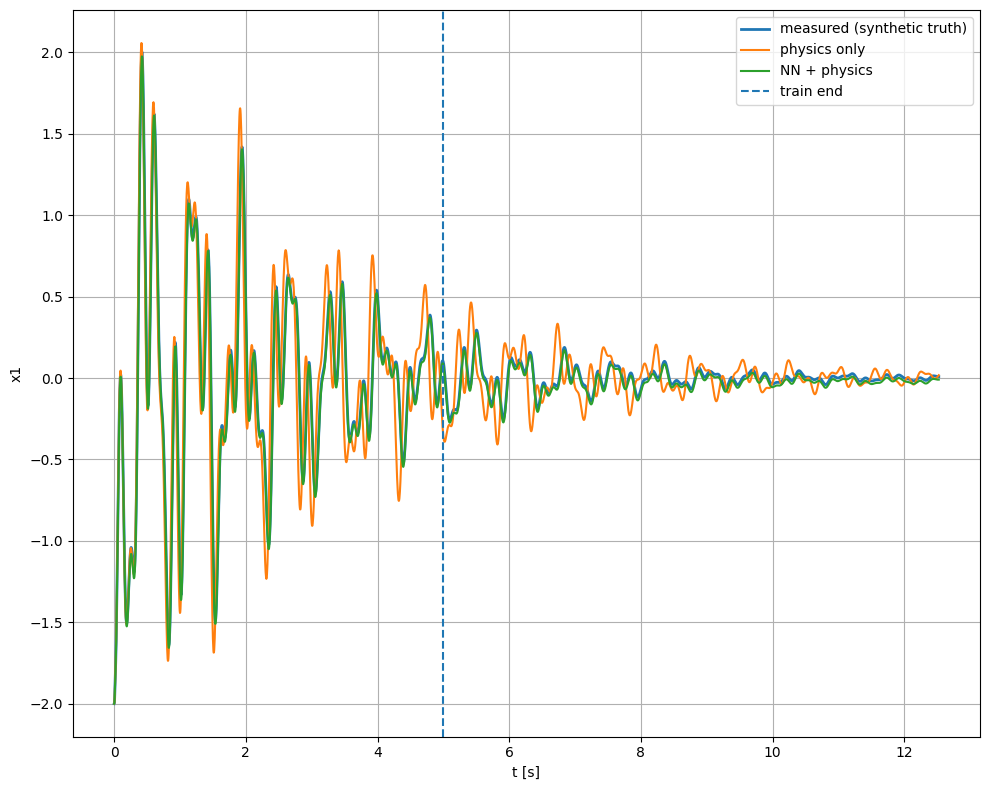

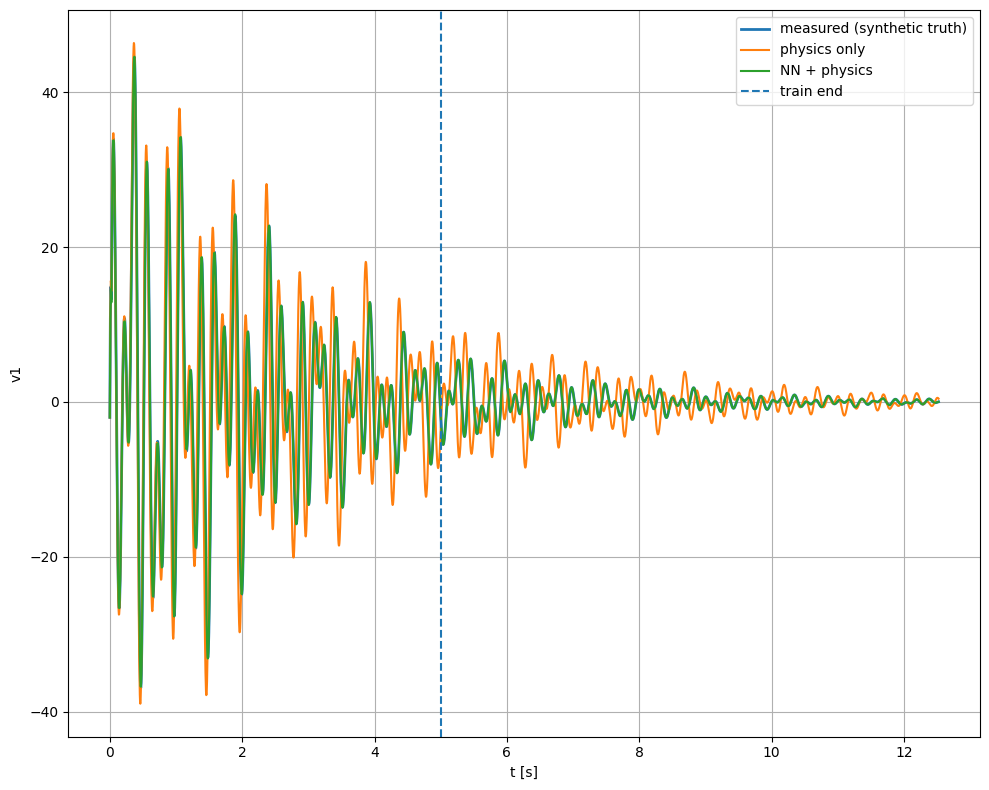

In [24]:
tt = t_full.detach().cpu()
train_end = float(t_train[-1].item())

def plot_three(traj_meas, traj_phys, traj_nn, idx, ylabel, save_path=None):

    fig = plt.figure(figsize=(10, 8))

    y_meas = traj_meas[:, idx].detach().cpu()
    y_phys = traj_phys[:, idx].detach().cpu()
    y_nn   = traj_nn[:, idx].detach().cpu()

    plt.plot(tt, y_meas, label="measured (synthetic truth)", lw=2)
    plt.plot(tt, y_phys, label="physics only")
    plt.plot(tt, y_nn,   label="NN + physics")
    plt.axvline(train_end, linestyle="--", label="train end")

    plt.xlabel("t [s]")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()

    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()



save_path_x = save_path + "exp3_noNSD_x1.png"
save_path_v = save_path + "exp3_noNSD_v1.png"
plot_three(traj_meas_full, traj_phys_full, pred_full, idx=0, ylabel="x1", save_path = save_path_x)
plot_three(traj_meas_full, traj_phys_full, pred_full, idx=3, ylabel="v1", save_path = save_path_v)


In [58]:
# layer 1: Linear(6->10), layer 2: Linear(10->3)
L1 = model.mlp[0]
L2 = model.mlp[1]

with torch.no_grad():
    W1 = L1.weight.detach()   # (10, 6)
    b1 = L1.bias.detach()     # (10,)
    W2 = L2.weight.detach()   # (3, 10)
    b2 = L2.bias.detach()     # (3,)

    # Effective map: a_disc = W_eff h + b_eff
    W_eff = W2 @ W1                  # (3, 6)
    b_eff = b2 + W2 @ b1             # (3,)


Wx = W_eff[:, :3]   # (3,3) multiplies x
Wv = W_eff[:, 3:]   # (3,3) multiplies v


with torch.no_grad():
    K_upd = K - (M @ Wx)   # (3,3)
    C_upd = C - (M @ Wv)   # (3,3)


In [59]:
print("K_true:\n", K_true)
print("K_upd:\n", K_upd)
print("K:\n", K)

print("C_true:\n", C_true)
print("C_upd:\n", C_upd)
print("C:\n", C)


K_true:
 tensor([[ 19.6522, -10.8252,   0.0000],
        [-10.8252,  19.7201,  -8.8949],
        [  0.0000,  -8.8949,   8.8949]])
K_upd:
 tensor([[ 19.6117, -10.8507,  -0.0329],
        [-10.7470,  19.8388,  -8.8922],
        [ -0.0199,  -8.8787,   8.8224]])
K:
 tensor([[ 20.2600, -11.1600,   0.0000],
        [-11.1600,  20.3300,  -9.1700],
        [  0.0000,  -9.1700,   9.1700]])
C_true:
 tensor([[0.0187, 0.0000, 0.0000],
        [0.0000, 0.0187, 0.0000],
        [0.0000, 0.0000, 0.0187]])
C_upd:
 tensor([[ 0.0254,  0.0095,  0.0102],
        [-0.0073,  0.0078, -0.0114],
        [ 0.0032,  0.0034,  0.0230]])
C:
 tensor([[0.0150, 0.0000, 0.0000],
        [0.0000, 0.0150, 0.0000],
        [0.0000, 0.0000, 0.0150]])


In [24]:
def nsd_force_bilinear(x1, d0=0.8, k_post=-10.0):

    # amount beyond threshold
    excess = torch.relu(torch.abs(x1) - d0)
    return k_post * excess * torch.sign(x1)

In [25]:
class TruthPhase2_3DOF(nn.Module):

    def __init__(self, M, K, C, B, nsd_force_fun):
        super().__init__()
        self.M, self.K, self.C, self.B = M, K, C, B
        self.nsd_force_fun = nsd_force_fun
        self.u_fun = None
        self.amp = 1.0

    def forward(self, t, h):
        x = h[..., :3]
        v = h[..., 3:]

        rhs = (-self.K @ x.unsqueeze(-1) - self.C @ v.unsqueeze(-1)).squeeze(-1)
        rhs = rhs + self.B * (self.amp * self.u_fun(t))  # base excitation

        # NSD force only on DOF1
        f_nsd = self.nsd_force_fun(x[..., 0])            # scalar force
        rhs[..., 0] = rhs[..., 0] + f_nsd                # add to DOF1 equation

        a = torch.linalg.solve(self.M, rhs.unsqueeze(-1)).squeeze(-1)

        dh = torch.zeros_like(h)
        dh[..., :3] = v
        dh[..., 3:] = a
        return dh


In [26]:
truth2 = TruthPhase2_3DOF(M_true, K_true, C_true, B_true, nsd_force_bilinear).to(device)
truth2.u_fun = UFunFromSamples(t_full, u_full)
truth2.amp = 1.0

with torch.no_grad():
    traj_meas2_full = odeint(truth2, h0_2, t_full, method="rk4")  # (T_full, 6)

traj_meas2_train = traj_meas2_full[:len(t_train)]


In [27]:
class NSD_Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 6 input features (x1, x2, x3, v1, v2, v3)
        # 20 hidden neurons, LeakyReLU activation
        self.mlp = nn.Sequential(
            nn.Linear(6, 20),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(20, 1)  # Only output 1 (acceleration correction for DOF1)
        )

    def forward(self, h):
        return self.mlp(h)  # Output is a single value (accel correction for DOF1)


In [28]:
class PINODEFuncScheme3_3DOF_with_NSD(nn.Module):
    def __init__(self, M, K, C, B, nn1_mlp, nn2_nsd):
        super().__init__()
        self.M = nn.Parameter(M.clone(), requires_grad=False)
        self.K = nn.Parameter(K.clone(), requires_grad=False)
        self.C = nn.Parameter(C.clone(), requires_grad=False)
        self.B = nn.Parameter(B.clone().view(3), requires_grad=False)

        self.mlp = nn1_mlp      # NN1 (frozen)
        self.nsd = nn2_nsd      # NN2 (trainable)

        self.amp = 1.0
        self.u_fun = lambda t: torch.zeros((), device=self.M.device)

    def forward(self, t, h):
        x = h[..., :3]
        v = h[..., 3:]

        # rhs = -Kx - Cv + B*u(t)   (NO in-place ops)
        rhs = (-self.K @ x.unsqueeze(-1) - self.C @ v.unsqueeze(-1)).squeeze(-1)
        u_t = self.amp * self.u_fun(t)          # scalar tensor
        rhs = rhs + self.B * u_t                # (3,)

        a_phys = torch.linalg.solve(self.M, rhs.unsqueeze(-1)).squeeze(-1)  # (3,)

        a_nn1 = self.mlp(h)                     # (3,)
        a_nn2 = self.nsd(h).squeeze(-1)         # scalar

        # add NSD only to DOF1 without in-place indexing
        zeros = torch.zeros_like(a_nn2)
        a_nsd_vec = torch.stack([a_nn2, zeros, zeros], dim=-1)  # (3,) broadcast-safe

        a = a_phys + a_nn1 + a_nsd_vec

        dh = torch.zeros_like(h)
        dh[..., :3] = v
        dh[..., 3:] = a
        return dh



In [29]:
# build phase-2 model
nn2 = NSD_Net().to(device)
model_nsd = PINODEFuncScheme3_3DOF_with_NSD(M, K, C, B, model.mlp, nn2).to(device)

# freeze NN1
for p in model_nsd.mlp.parameters():
    p.requires_grad = False



In [31]:
save_model_path = "/content/drive/MyDrive/pinode_models/exp3_5k_NSD_V2_10K.pth"
loss_log_path = "/content/drive/MyDrive/pinode_models/exp3_5k_NSD_V2_10K.npy"

loss_history_init = np.load(loss_log_path)

model_nsd.load_state_dict(torch.load(save_model_path, map_location=device))

# model_nsd, loss_hist = train_scheme_with_disc_singleIC_singleEQ_exp3_no_nsd(
#     scheme=3,
#     model=model_nsd,
#     h0=h0_2,
#     traj_true=traj_meas2_train,
#     t_train=t_train,
#     u_grid=u_train,
#     amp_scale=1.0,
#     num_epochs=5000,
#     lr=1e-3,
#     log_interval=20,
#     loss_log_path=loss_log_path,
#     save_model_path=save_model_path,
#     loss_history_init=loss_history_init,
# )

<All keys matched successfully>

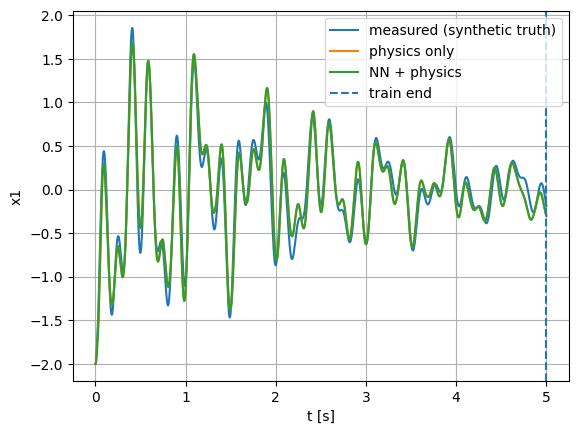

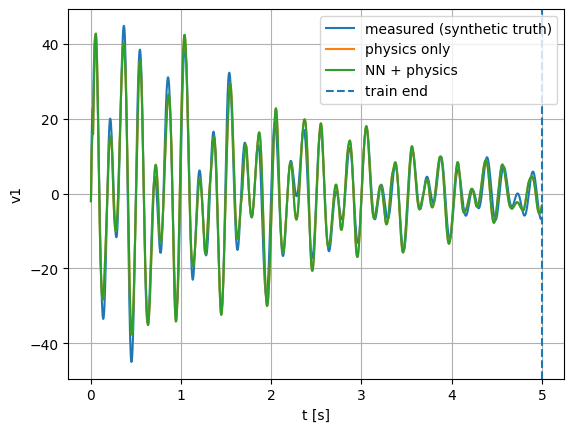

In [35]:
tt = t_train.detach().cpu()

def plot_three_nsd(traj_meas, traj_phys, traj_nn, idx, ylabel):
    y_meas = traj_meas[:, idx].detach().cpu()
    y_phys = traj_phys[:, idx].detach().cpu()
    y_nn   = traj_nn[:, idx].detach().cpu()

    plt.figure()
    plt.plot(tt, y_meas, label="measured (synthetic truth)")
    plt.plot(tt, y_phys, label="phys + NN1 + NN2")
    plt.plot(tt, y_nn,   label="phys + NN1 + NN2")
    plt.axvline(train_end, linestyle="--", label="train end")
    plt.xlabel("t [s]")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()


# --- set the forcing on the full horizon ---
model_nsd.eval()
model_nsd.u_fun = UFunFromSamples(t_train, u_train)
model_nsd.amp = 1.0

# --- extrapolate ---
with torch.no_grad():
    pred_train_nsd = odeint(model_nsd, h0_2, t_train, method="rk4")  # (N_full, 6)
    pred_train = odeint(model, h0_2, t_train, method="rk4")  # (N_full, 6)

plot_three(traj_meas2_train, pred_train_nsd, pred_train_nsd , idx=0, ylabel="x1")
plot_three(traj_meas2_train, pred_train_nsd, pred_train_nsd, idx=3, ylabel="v1")